## やること
* Lineage別に大陸ごとに色付けして月別にプロット
    * Lineage別に国ごとに色付けして月別にプロット
* 大陸別にLineageごとに色付けして月別にプロット
    * 国別に国ごとに色付けして月別にプロット

In [1]:
import sys
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import copy
from tqdm import tqdm

from collections import defaultdict

from datareading.blsom import blsom_all_plot, blsom_plot_3d, weight_file2df
from datareading.omicron import CreateOmicronHeaderDF, Show2DImage, Show3DImage, blsom_outfile_to_df

from color import targets

import warnings
warnings.simplefilter('ignore')
plt.rcParams["font.family"] = "Times New Roman"

DATA_COLUMNS = ["year", "month", "day"]
CLADE_COLUMNS = ["clade", "head2"]

JAPAN_HEADER_COLUMNS = ["head", "ID", "date"]
DELTA_HEADER_COLUMNS = ["head", "collection date", "submission date"]

ALL_DATA_HEADER_COLUMNS = [
    "head",
    "id",
    "continent",
    "country",
    "city",
    "host",
    "clade_head",
    "collection date",
]

# pd.set_option('display.max_columns', 50)


#行数
# pd.set_option("display.max_rows")

# Delta型Header

In [2]:
COMPARE_PASSED = True
DATA_DIR = "omicron2201"
# file = f"{DATA_DIR}/ReceivedData/dataToFurukawa/Omicron.meta.id.fas.N1.id.meta"
# filename = f"{DATA_DIR}/ReceivedData/SOM/out_each_region"
IMAGE_OUTPUT = f"{DATA_DIR}/output/images"

file = f"{DATA_DIR}/ReceivedData/dataToFurukawa/Omicron.meta.id.fas.N1.id.meta"
filename = f"{DATA_DIR}/ReceivedData/SOM/out_all"

createdf = CreateOmicronHeaderDF(
    out_filename=filename,
    meta_filename=file,
    # weight_file=f"{DATA_DIR}/ReceivedData/dataToFurukawa/weight.100",
    # weight_file=f"{DATA_DIR}/ReceivedData/dataToFurukawa/weight.100",
)
createdf.create_df()

delta_blsom = createdf.delta_blsom
X = createdf.X
Y = createdf.Y

if COMPARE_PASSED:
    # ShowImage(delta_blsom, X, Y).show_color_by_continent()
    new_lin_file = f"{DATA_DIR}/ReceivedData/dataToFurukawa/Omicron.meta.id.fas.N1.lin"

    new_delta_header = pd.read_csv(new_lin_file, sep="\t")
    new_delta_header = new_delta_header.rename(columns={"lineage": "new_lineage"})

    delta_blsom = delta_blsom.merge(
        new_delta_header[["taxon", "new_lineage"]],
        right_on="taxon",
        left_on="Virus name",
        how="left",
    )
print(X, Y)

300 210


In [3]:
delta_blsom.head(5) # 248574

Virus name     x y  distance    x   y             Type  \
0  South Africa/NICD-N23184/2021   89 21    0.1585   89  21  betacoronavirus   
1  South Africa/NICD-N23182/2021  202 40    0.3077  202  40  betacoronavirus   
2  South Africa/NICD-N22610/2021   98 18    0.0896   98  18  betacoronavirus   
3  South Africa/NICD-N22615/2021  225 23    0.2423  225  23  betacoronavirus   
4  South Africa/NICD-N22617/2021   88 23    0.0166   88  23  betacoronavirus   

      Accession ID Collection date                               Location  \
0  EPI_ISL_7971626      2021-12-04     Africa / South Africa / North West   
1  EPI_ISL_7971624      2021-12-03  Africa / South Africa / Northern Cape   
2  EPI_ISL_7740859      2021-11-25        Africa / South Africa / Gauteng   
3  EPI_ISL_7740860      2021-11-25        Africa / South Africa / Gauteng   
4  EPI_ISL_7740861      2021-11-24        Africa / South Africa / Gauteng   

  Additional location information  ...  year month day continent  \
0                             NaN  ...  2021    12  04    Africa   
1                             NaN  ...  2021    12  03    Africa   
2                             NaN  ...  2021    11  25    Africa   
3                             NaN  ...  2021    11  25    Africa   
4                             NaN  ...  2021    11  24    Africa   

        country           city     3     4                          taxon  \
0  South Africa     North West  None  None  South Africa/NICD-N23184/2021   
1  South Africa  Northern Cape  None  None  South Africa/NICD-N23182/2021   
2  South Africa        Gauteng  None  None  South Africa/NICD-N22610/2021   
3  South Africa        Gauteng  None  None  South Africa/NICD-N22615/2021   
4  South Africa        Gauteng  None  None  South Africa/NICD-N22617/2021   

  new_lineage  
0        BA.1  
1        BA.1  
2        BA.1  
3        BA.1  
4        BA.1  

[5 rows x 36 columns]

In [4]:
# delta_blsom1

In [5]:
# delta_blsom.to_csv("ANALYTICS_CLUSTER/ALL.tsv", sep="\t", index=False)

In [6]:
# delta_blsom["Type"].value_counts()
# delta_blsom["Location"].value_counts()
# delta_blsom["Host"].value_counts()
# delta_blsom["Pango lineage"].value_counts()
# delta_blsom["Patient age"].value_counts()
# delta_blsom["Gender"].value_counts()
# delta_blsom["continent"].value_counts()
delta_blsom["country"].value_counts().index
# delta_blsom["Variant"].value_counts()
# delta_blsom["year"].value_counts()
# delta_blsom["month"].value_counts()
delta_blsom["lineage"].value_counts()

BA.1         238547
BA.2           7923
B.1.1.529      2064
BA.3             40
Name: lineage, dtype: int64

In [7]:
from color import define_rgb_color
# classes = delta_blsom[delta_blsom["continent"]==con][target].unique()
target="continent"
classes = delta_blsom[target].unique()
rgb_color = define_rgb_color(classes, target)
rgb_color

{'Asia': Color(color_name='aqua', hex='#00FFFF', rgb=(0, 255, 255), target=''),
 'Oceania': Color(color_name='blue', hex='#0000FF', rgb=(0, 0, 255), target=''),
 'Africa': Color(color_name='fuchsia', hex='#FF00FF', rgb=(255, 0, 255), target=''),
 'North_America': Color(color_name='lime', hex='#00FF00', rgb=(0, 255, 0), target=''),
 'Europe': Color(color_name='red', hex='#FF0000', rgb=(255, 0, 0), target=''),
 'South_America': Color(color_name='yellow', hex='#FFFF00', rgb=(255, 255, 0), target='')}

# 全体図プロット

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


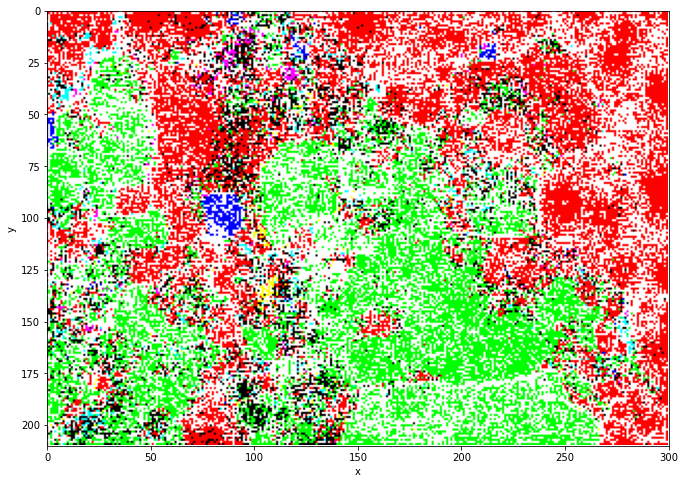

In [8]:
plt.figure(figsize=(12, 8))
img = blsom_all_plot(delta_blsom, rgb_color=rgb_color, target=target)
#     plt.subplot(3, 2, i+1)
#     ax = plt.gca()
#     ax.axes.xaxis.set_visible(False)
#     ax.axes.yaxis.set_visible(False)
# plt.title(f"{con}")
#     plt.title(f"{con}+{target}")
plt.xlim(0,X)
plt.ylim(Y,0)
plt.xlabel("x")
plt.ylabel("y")
plt.imshow(img)
plt.savefig(f"{IMAGE_OUTPUT}/Omicron2D.png")
# plt.clf()

# 大陸別プロット

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


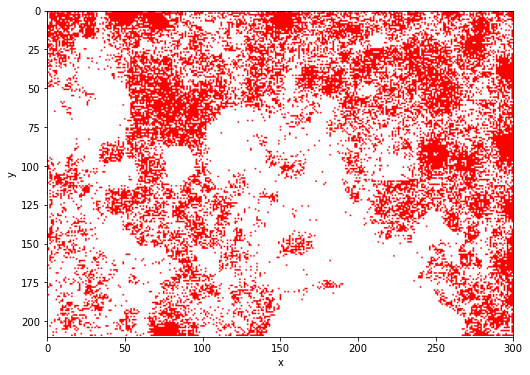

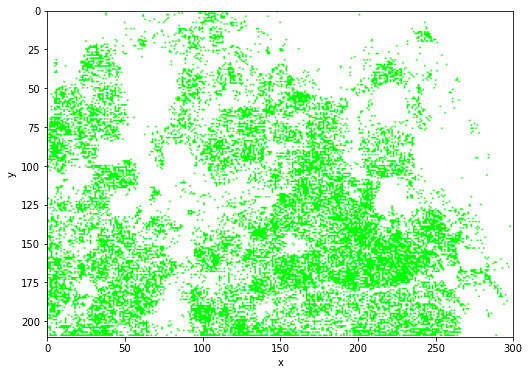

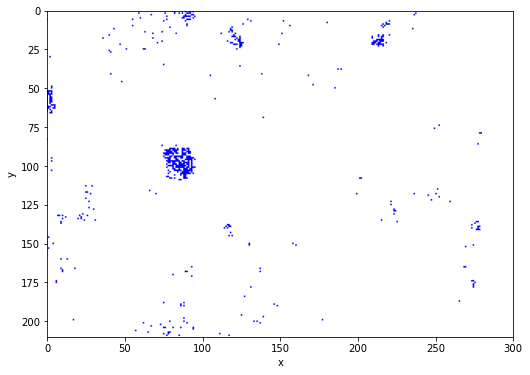

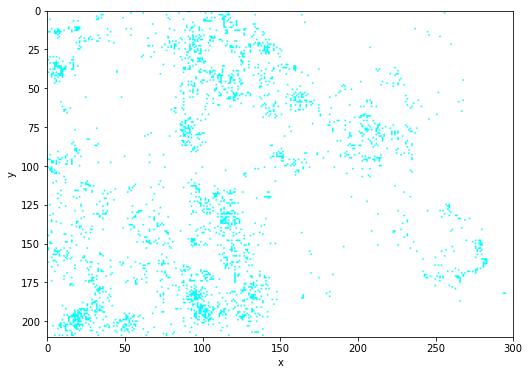

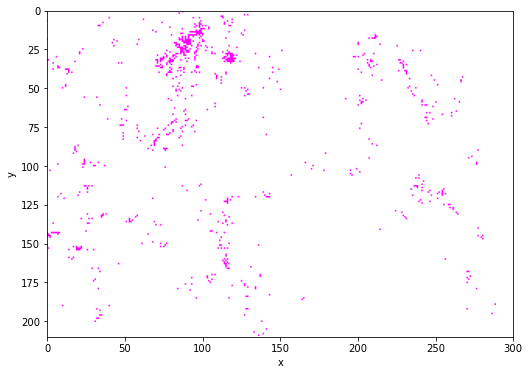

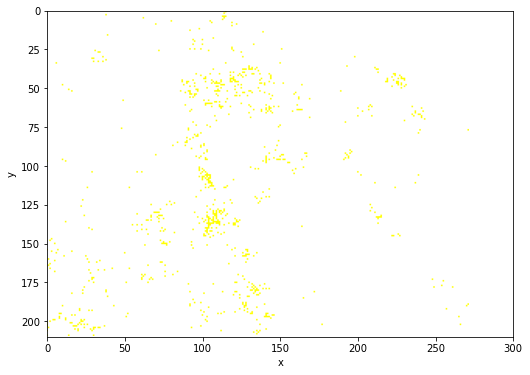

In [8]:
target="continent"
for i, con in enumerate(targets["continent"].keys()):
    plt.figure(figsize=(10, 6))
    img = blsom_all_plot(delta_blsom[delta_blsom["continent"]==con], rgb_color=rgb_color, target=target)
#     plt.subplot(3, 2, i+1)
#     ax = plt.gca()
#     ax.axes.xaxis.set_visible(False)
#     ax.axes.yaxis.set_visible(False)
#     plt.title(f"{con}")
#     plt.title(f"{con}+{target}")
    plt.xlim(0,X)
    plt.ylim(Y,0)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.imshow(img)
    plt.savefig(f"{IMAGE_OUTPUT}/{con}2D.png")
#     plt.clf()

# 大陸月別プロット

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


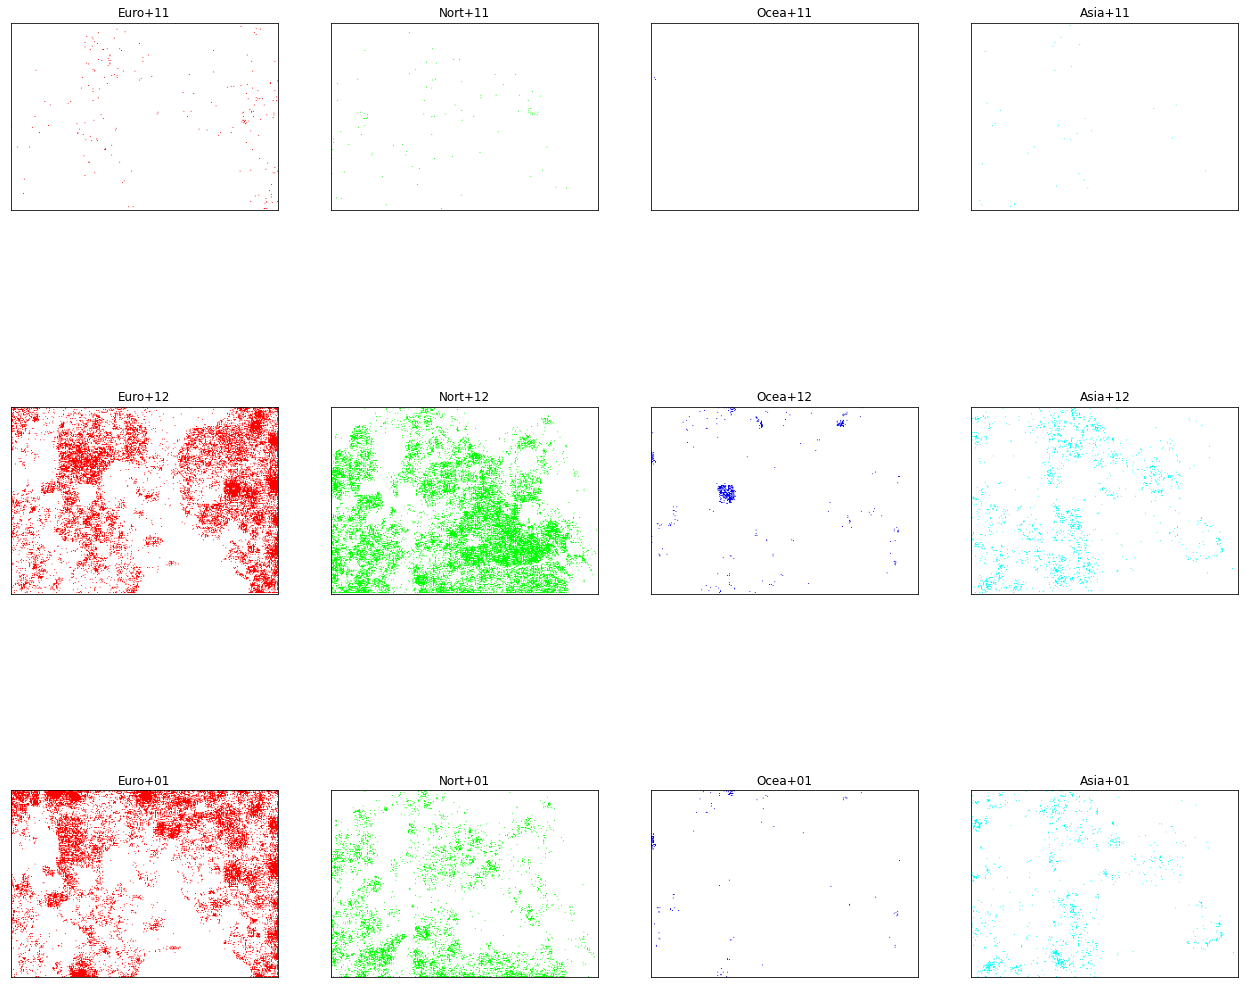

In [8]:
target="continent"
plt.figure(figsize=(22, 20))
num = 0
for j, mon in enumerate(targets["month"].keys()):
    for i, con in enumerate(targets["continent4"].keys()):
        if mon in delta_blsom["month"].unique():
            num += 1
            img = blsom_all_plot(delta_blsom[(delta_blsom["month"]==mon) & (delta_blsom["continent"]==con)], rgb_color=rgb_color, target=target)
            plt.subplot(3, 4, num) # subplot(m, n, p): mは行, nは列, pは位置 → mは2や3だと上下離れてしまうので5にしています
            plt.title(f"{con[:4]}+{mon}")
            ax = plt.gca()
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
            plt.xlim(0,X)
            plt.ylim(Y,0)
            if img is not None:
                plt.imshow(img)
            else:
                plt.imshow(np.full((X+1, Y+1, 3), [255,255,255]))
plt.savefig(f"{IMAGE_OUTPUT}/Omicron_month.png")

In [13]:
delta_blsom["month"].value_counts()

12    156347
01     90189
11      1221
Name: month, dtype: int64

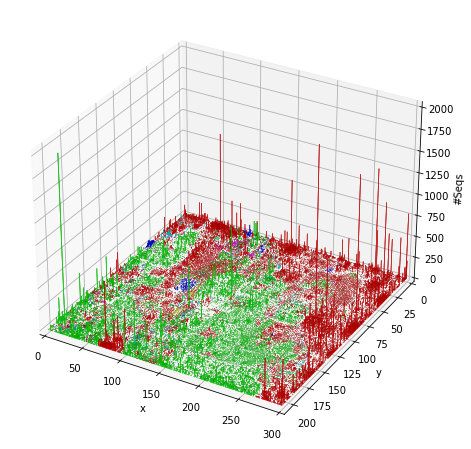

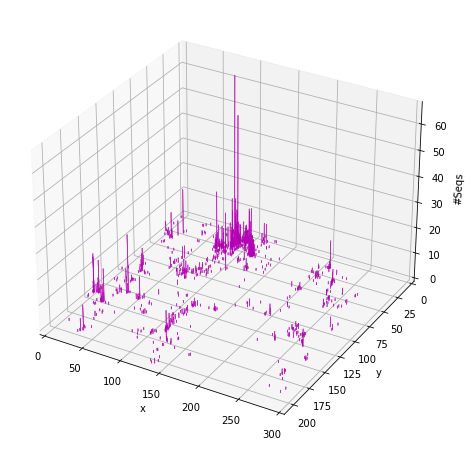

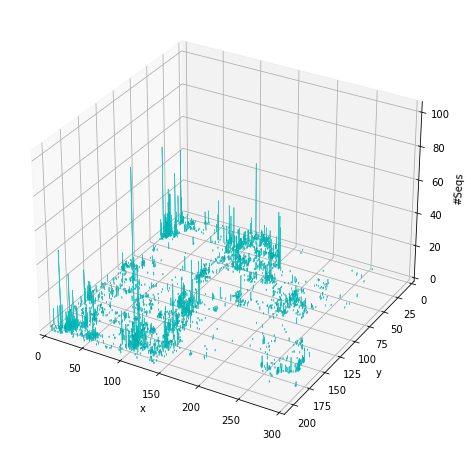

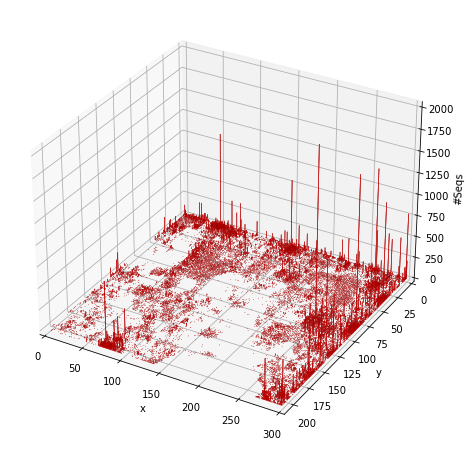

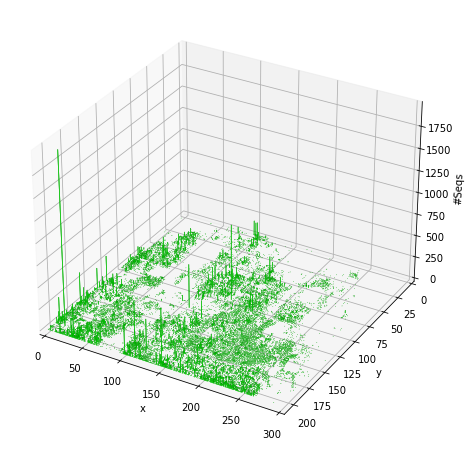

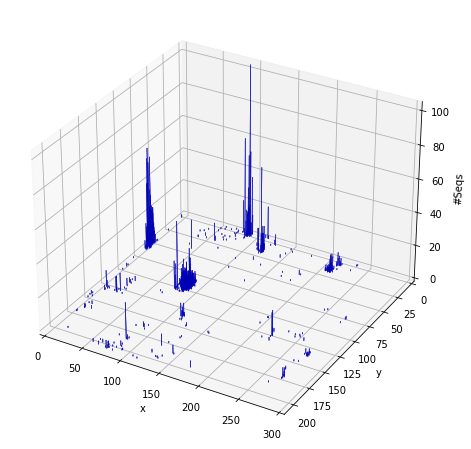

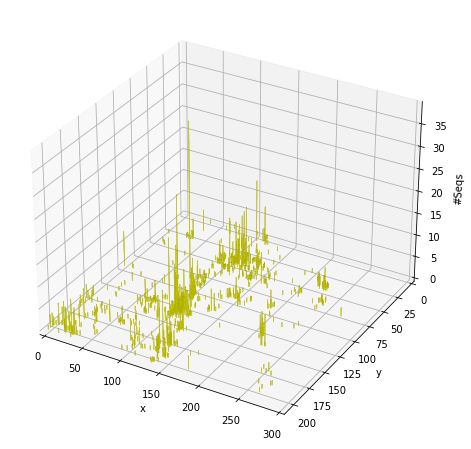

In [14]:
target="continent"
s = Show3DImage(X, Y, rgb_color, delta_blsom)
s.plot(title="", target=target, output_file=f"{IMAGE_OUTPUT}/Omicron3D.png")

# 大陸ごと
for i in delta_blsom["continent"].unique():
    by3d = delta_blsom[(delta_blsom["continent"] == i)]
    s = Show3DImage(X, Y, rgb_color, by3d)
    s.plot(title="", target=target, output_file=f"{IMAGE_OUTPUT}/{i}_country3D.png")

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


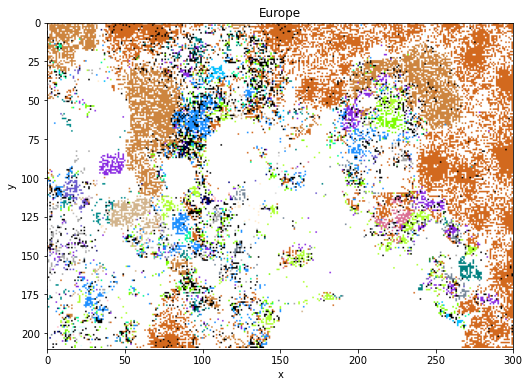

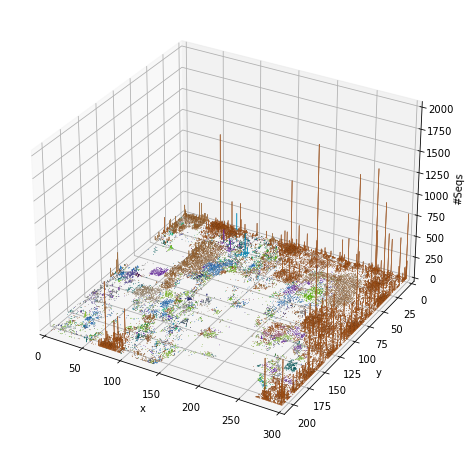

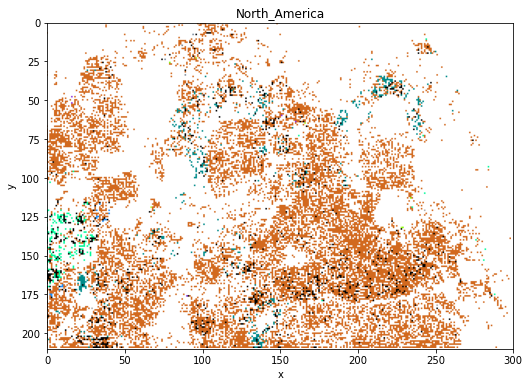

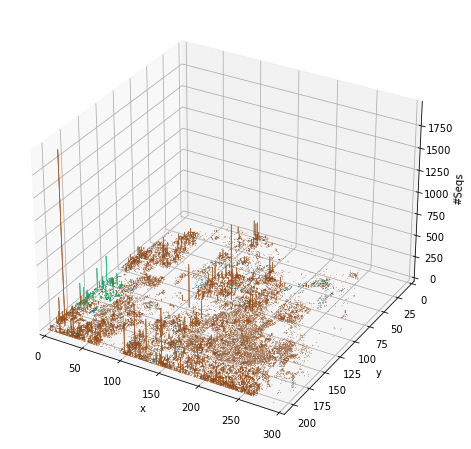

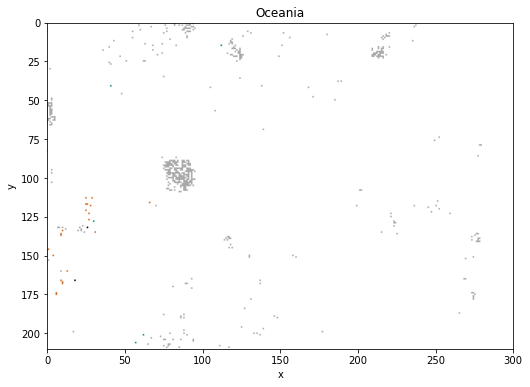

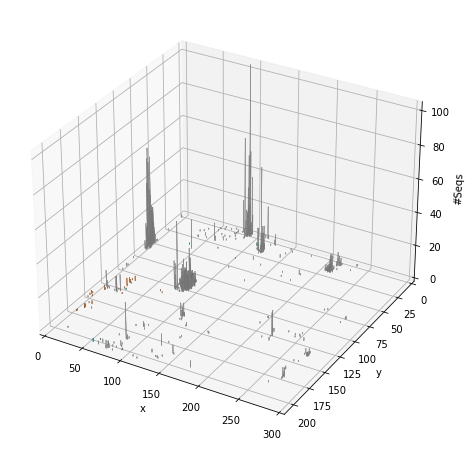

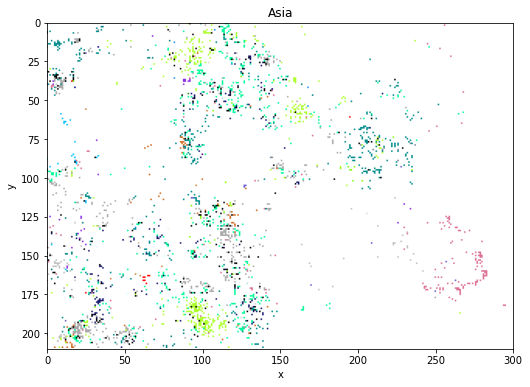

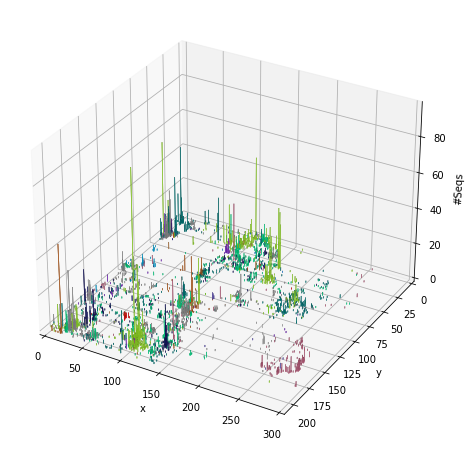

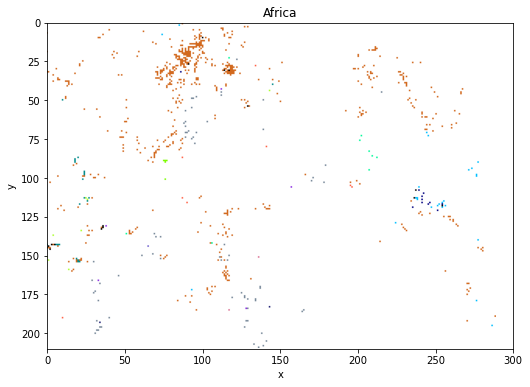

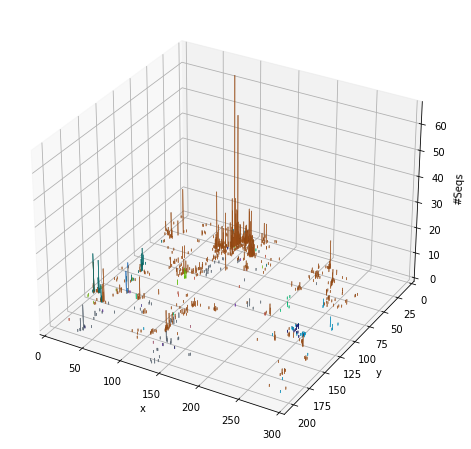

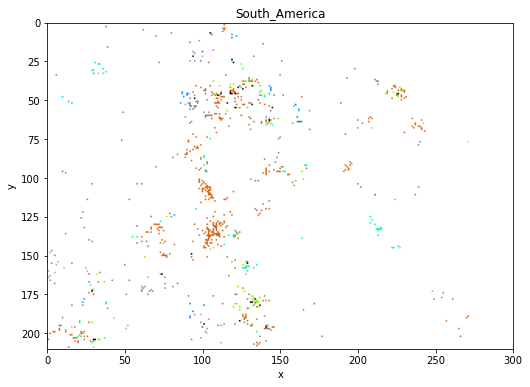

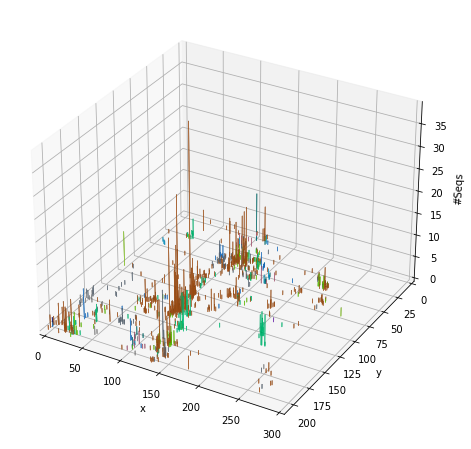

In [10]:
target="country"
for i, con in enumerate(targets["continent"].keys()):
    plt.figure(figsize=(10, 6))
    continent_df = delta_blsom[delta_blsom["continent"]==con]
    classes = continent_df[target].unique()
    rgb_color = define_rgb_color(classes, seed=2)

    img = blsom_all_plot(continent_df, rgb_color=rgb_color, target=target)
#     plt.subplot(3, 2, i+1)
#     ax = plt.gca()
#     ax.axes.xaxis.set_visible(False)
#     ax.axes.yaxis.set_visible(False)
    plt.title(f"{con}")
#     plt.title(f"{con}+{target}")
    plt.xlim(0,X)
    plt.ylim(Y,0)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.imshow(img)
    plt.savefig(f"{IMAGE_OUTPUT}/{con}_country2D.png")
#     plt.clf()

    s = Show3DImage(X, Y, rgb_color, continent_df)
    s.plot(title="", target=target, output_file=f"{IMAGE_OUTPUT}/{con}_country3D.png")

In [16]:
delta_blsom['Submission date'] = pd.to_datetime(delta_blsom['Submission date'], format="%Y-%m-%d")
con_mon = [(con, i) for i in sorted(delta_blsom['Submission date'].unique())]

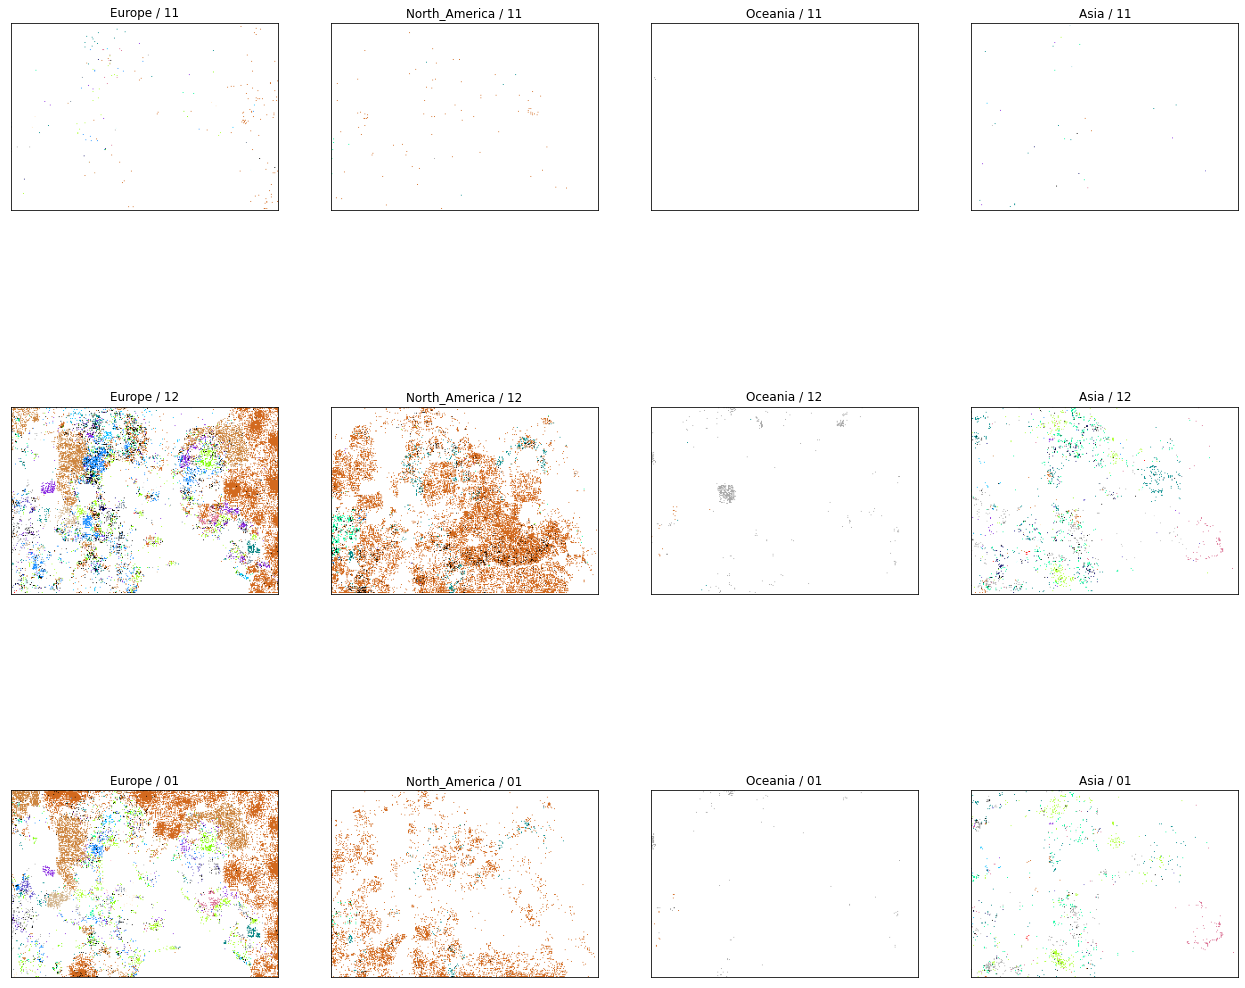

In [11]:
%matplotlib inline
# target="new_lineage"
target="country"
# con = "Europe"
plt.figure(figsize=(22, 20))
num = 0
for j, mon in enumerate(targets["month"].keys()):
    for i, con in enumerate(targets["continent4"].keys()):
        if mon in delta_blsom["month"].unique():
            continent_df = delta_blsom[delta_blsom["continent"]==con]
            classes = continent_df[target].unique()
            rgb_color = define_rgb_color(classes, seed=2)
                        
            num += 1
            img = blsom_all_plot(delta_blsom[(delta_blsom["month"]==mon) & (delta_blsom["continent"]==con)], rgb_color=rgb_color, target=target)
            plt.subplot(3, 4, num) # subplot(m, n, p): mは行, nは列, pは位置 → mは2や3だと上下離れてしまうので5にしています
            plt.title(f"{con} / {mon}")
            ax = plt.gca()
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
            plt.xlim(0,X)
            plt.ylim(Y,0)
            if img is not None:
                plt.imshow(img)
            else:
                plt.imshow(np.full((X+1, Y+1, 3), [255,255,255]))
plt.savefig(f"{IMAGE_OUTPUT}/Omicron_month_{target}.png")

In [17]:
%matplotlib notebook
 
from matplotlib import animation

 
def plot(data, target):
    plt.cla() # 前のグラフを削除
    print(data)
    # print(con_mon)
    if data >= len(con_mon):
        return
    print(con_mon[data])
    con, date = con_mon[data]
    # df = delta_blsom[(delta_blsom['Submission date']<=date-np.timedelta64(10, 'D')) & (delta_blsom['Submission date']<=date) & (delta_blsom["continent"]==con)]
    df = delta_blsom[(delta_blsom['Submission date']<=date) & (delta_blsom["continent"]==con)]
    img = blsom_all_plot(df, rgb_color=rgb_color, target=target)
    
    plt.title(f"{con} / {str(date)[:10]}")
    plt.tick_params(bottom=False, left=False, right=False, top=False)

    plt.xlim(0,X)
    plt.ylim(Y,0)
    if img is not None:
        plt.imshow(img)
    else:
        plt.imshow(np.full((X+1, Y+1, 3), [255,255,255]))

def color_background_lightgreen(color):
    if color[0] == "#":
        return 'background-color: %s' % color

fig = plt.figure()

continents = ["Europe", "North_America", "Oceania", "Asia"]
target = "country"

for con in continents:
    delta_blsom['Submission date'] = pd.to_datetime(delta_blsom['Submission date'], format="%Y-%m-%d")
    con_mon = [(con, i) for i in sorted(delta_blsom['Submission date'].unique())]

    classes = delta_blsom[delta_blsom["continent"]==con][target].unique()
    rgb_color = define_rgb_color(classes, seed=2)

    df = pd.DataFrame.from_dict(rgb_color, orient="index")
    df.style.applymap(color_background_lightgreen).to_excel(f'{IMAGE_OUTPUT}/{con}_{target}_color.xlsx', index=False)
    # df.style.applymap(color_background_lightgreen).to_excel(f'{IMAGE_OUTPUT}/{con}/{con}_{target}_color.xlsx', index=False)

    # 10msごとにplot関数を呼び出してアニメーションを作成
    ani = animation.FuncAnimation(fig, plot, fargs=(target,), interval=500, blit=True, repeat=False, save_count=len(con_mon))
    # FFwriter=animation.FFMpegWriter(fps=10, extra_args=['-vcodec', 'libx264'])
    ani.save(f'{IMAGE_OUTPUT}/{con}_{target}.gif', writer='imagemagick')
    # ani.save(f'{IMAGE_OUTPUT}/{con}/{con}_{target}.gif', writer='imagemagick')
    # plt.show()

<IPython.core.display.Javascript object>

MovieWriter imagemagick unavailable; using Pillow instead.


0
('Europe', numpy.datetime64('2021-11-22T00:00:00.000000000'))
0
('Europe', numpy.datetime64('2021-11-22T00:00:00.000000000'))
1
('Europe', numpy.datetime64('2021-11-23T00:00:00.000000000'))
2
('Europe', numpy.datetime64('2021-11-25T00:00:00.000000000'))
3
('Europe', numpy.datetime64('2021-11-27T00:00:00.000000000'))
4
('Europe', numpy.datetime64('2021-11-28T00:00:00.000000000'))
5
('Europe', numpy.datetime64('2021-11-29T00:00:00.000000000'))
6
('Europe', numpy.datetime64('2021-11-30T00:00:00.000000000'))
7
('Europe', numpy.datetime64('2021-12-01T00:00:00.000000000'))
8
('Europe', numpy.datetime64('2021-12-02T00:00:00.000000000'))
9
('Europe', numpy.datetime64('2021-12-03T00:00:00.000000000'))
10
('Europe', numpy.datetime64('2021-12-04T00:00:00.000000000'))
11
('Europe', numpy.datetime64('2021-12-05T00:00:00.000000000'))
12
('Europe', numpy.datetime64('2021-12-06T00:00:00.000000000'))
13
('Europe', numpy.datetime64('2021-12-07T00:00:00.000000000'))
14
('Europe', numpy.datetime64('2021

MovieWriter imagemagick unavailable; using Pillow instead.


0
('North_America', numpy.datetime64('2021-11-22T00:00:00.000000000'))
0
('North_America', numpy.datetime64('2021-11-22T00:00:00.000000000'))
1
('North_America', numpy.datetime64('2021-11-23T00:00:00.000000000'))
2
('North_America', numpy.datetime64('2021-11-25T00:00:00.000000000'))
3
('North_America', numpy.datetime64('2021-11-27T00:00:00.000000000'))
4
('North_America', numpy.datetime64('2021-11-28T00:00:00.000000000'))
5
('North_America', numpy.datetime64('2021-11-29T00:00:00.000000000'))
6
('North_America', numpy.datetime64('2021-11-30T00:00:00.000000000'))
7
('North_America', numpy.datetime64('2021-12-01T00:00:00.000000000'))
8
('North_America', numpy.datetime64('2021-12-02T00:00:00.000000000'))
9
('North_America', numpy.datetime64('2021-12-03T00:00:00.000000000'))
10
('North_America', numpy.datetime64('2021-12-04T00:00:00.000000000'))
11
('North_America', numpy.datetime64('2021-12-05T00:00:00.000000000'))
12
('North_America', numpy.datetime64('2021-12-06T00:00:00.000000000'))
13


MovieWriter imagemagick unavailable; using Pillow instead.


0
('Oceania', numpy.datetime64('2021-11-22T00:00:00.000000000'))
0
('Oceania', numpy.datetime64('2021-11-22T00:00:00.000000000'))
1
('Oceania', numpy.datetime64('2021-11-23T00:00:00.000000000'))
2
('Oceania', numpy.datetime64('2021-11-25T00:00:00.000000000'))
3
('Oceania', numpy.datetime64('2021-11-27T00:00:00.000000000'))
4
('Oceania', numpy.datetime64('2021-11-28T00:00:00.000000000'))
5
('Oceania', numpy.datetime64('2021-11-29T00:00:00.000000000'))
6
('Oceania', numpy.datetime64('2021-11-30T00:00:00.000000000'))
7
('Oceania', numpy.datetime64('2021-12-01T00:00:00.000000000'))
8
('Oceania', numpy.datetime64('2021-12-02T00:00:00.000000000'))
9
('Oceania', numpy.datetime64('2021-12-03T00:00:00.000000000'))
10
('Oceania', numpy.datetime64('2021-12-04T00:00:00.000000000'))
11
('Oceania', numpy.datetime64('2021-12-05T00:00:00.000000000'))
12
('Oceania', numpy.datetime64('2021-12-06T00:00:00.000000000'))
13
('Oceania', numpy.datetime64('2021-12-07T00:00:00.000000000'))
14
('Oceania', numpy.

MovieWriter imagemagick unavailable; using Pillow instead.


0
('Asia', numpy.datetime64('2021-11-22T00:00:00.000000000'))
0
('Asia', numpy.datetime64('2021-11-22T00:00:00.000000000'))
1
('Asia', numpy.datetime64('2021-11-23T00:00:00.000000000'))
2
('Asia', numpy.datetime64('2021-11-25T00:00:00.000000000'))
3
('Asia', numpy.datetime64('2021-11-27T00:00:00.000000000'))
4
('Asia', numpy.datetime64('2021-11-28T00:00:00.000000000'))
5
('Asia', numpy.datetime64('2021-11-29T00:00:00.000000000'))
6
('Asia', numpy.datetime64('2021-11-30T00:00:00.000000000'))
7
('Asia', numpy.datetime64('2021-12-01T00:00:00.000000000'))
8
('Asia', numpy.datetime64('2021-12-02T00:00:00.000000000'))
9
('Asia', numpy.datetime64('2021-12-03T00:00:00.000000000'))
10
('Asia', numpy.datetime64('2021-12-04T00:00:00.000000000'))
11
('Asia', numpy.datetime64('2021-12-05T00:00:00.000000000'))
12
('Asia', numpy.datetime64('2021-12-06T00:00:00.000000000'))
13
('Asia', numpy.datetime64('2021-12-07T00:00:00.000000000'))
14
('Asia', numpy.datetime64('2021-12-08T00:00:00.000000000'))
15
